In [1]:
### Testing and visualizing cutblur boundaries (Konstantin Georgiev) 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

from skimage.io import imread, imshow
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.filters import gaussian
from skimage import data, color

#### Image processing

In [2]:
def augment_image( im1,                    # Image 1
                    im2,                    # Image 2
                    augs,                   # Augments to select from
                    probs,                  # Probabilities to use in each augments parameters
                    alphas,                 # The alpha values for each mix
                    mix_p = None            # Probability of selecting an augment
                    ):

    # Choose a random index to select an augment and its respective parametes
    idx = np.random.choice(len(augs), p=mix_p)
    aug = augs[idx]
    prob = float(probs[idx])
    alpha = float(alphas[idx])
    mask = None


    # Do not augment the images, just return copies of the originals
    if aug == "none":
        im1_aug, im2_aug = im1.clone(), im2.clone()
    elif aug == "cutblur":
        im1_aug, im2_aug = cutblur( im1.clone(), im2.clone(),
                                    prob=prob, alpha=alpha )

    return im1_aug, im2_aug, mask, aug


# CutBlur Code
def cutblur(im1, im2, prob=1.0, alpha=0.5, production=True):
    # If alpha doesnt make sense or if the number is higher than the probability
    # do not perform the augmentation.
    if im1.size() != im2.size():
        raise ValueError("im1 and im2 have to be the same resolution.")
    if alpha <= 0 or np.random.rand(1) >= prob:
        return im1, im2

    # Generate a random cut ratio
    cut_ratio = np.random.randn() * 0.01 + alpha

    # The boundaries of the patch to cut and paste
    h, w = im2.size(2), im2.size(3)                     # get height and width
    ch, cw = np.int(h*cut_ratio), np.int(w*cut_ratio)   # get height and width of patch

    cy = np.random.randint(0, h-ch+1)                   # random y cordinate of patch
    cx = np.random.randint(0, w-cw+1)                   # random x cordinate of patch
    

    # Perform the cutblur
    if np.random.random() > 0.5:
        im2[..., cy:cy+ch, cx:cx+cw] = im1[..., cy:cy+ch, cx:cx+cw]
    else:
        im2_aug = im1.clone()
        im2_aug[..., cy:cy+ch, cx:cx+cw] = im2[..., cy:cy+ch, cx:cx+cw]
        im2 = im2_aug
        
    if production:
        # Export the image coordinates for visualization 
        region_dict = {
        'cy': cy,
        'cx': cx,
        'ch': ch,
        'cw': cw
        }
        return im1, im2, region_dict
    
    return im1, im2

In [3]:
# These are taken from the paper but I added unsqueeze() in the im2tensor
def im2tensor(im):
    np_t = np.ascontiguousarray(im.transpose((2, 0, 1)))
    tensor = torch.from_numpy(np_t).float().unsqueeze(0)
    return tensor

def tensor2im(tensor):
    tensor = tensor.detach().squeeze(0)
    im = tensor.clamp(0, 255).round().cpu().byte().permute(1, 2, 0).numpy()
    return im

In [4]:
def blur_img(img, sigma=2, truncate=2.5, multichannel=True):
    blurred = gaussian(img, sigma=sigma, truncate=truncate, multichannel=multichannel)
    return blurred

def downsize_img(img, factor=2):
    image_resized = resize(img, (img.shape[0] // factor, img.shape[1] // factor),
                       anti_aliasing=False)
    return image_resized

def downsample_img(img, factor=2):
    downsampled = resize(img, (img.shape[0] // factor, img.shape[1] // factor), order=1, mode='reflect', 
                             clip=True, preserve_range=True, anti_aliasing=True)
    upsampled = resize(downsampled, img.shape, order=0, mode='reflect', 
                             clip=True, preserve_range=True, anti_aliasing=False)
    return upsampled / 255

def blend_img(or_img, cut_img, alpha=0.8):
    mask1 = or_img.copy()
    mask2 = cut_img.copy()
    blended = alpha * mask1 + (1 - alpha) * mask2
    return blended / 255

def vis_regions(cut_blurred_img, region_dict, figsize=(8,8)):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
    ax.imshow(cut_blurred_img)
    rect = mpatches.Rectangle((region_dict['cx'], region_dict['cy']), 
                              region_dict['cw'],
                              region_dict['ch'],
                              fill=False, edgecolor='lime', linewidth=4)
    ax.add_patch(rect)
    plt.axis('off')
    plt.show()

def plot_img(img, figsize=(8,8)):
    plt.figure(figsize=figsize)
    imshow(img)
    plt.axis('off')
    plt.show()

#### Test augmentation with sample image

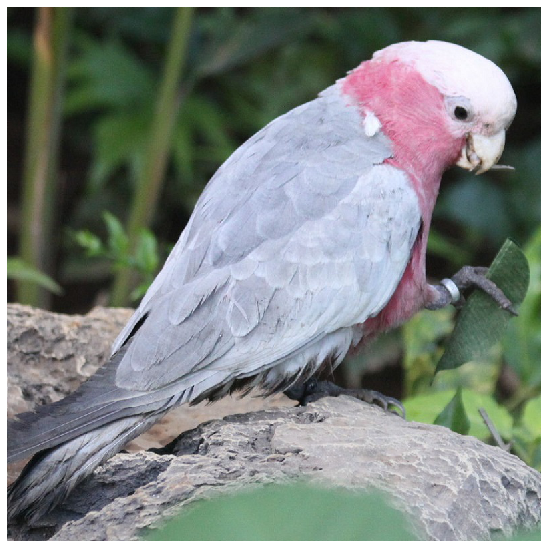

In [5]:
hr_img = imread('Galah-cockatoo.jpg')
plot_img(hr_img)

In [6]:
print(hr_img.shape)

(800, 800, 3)


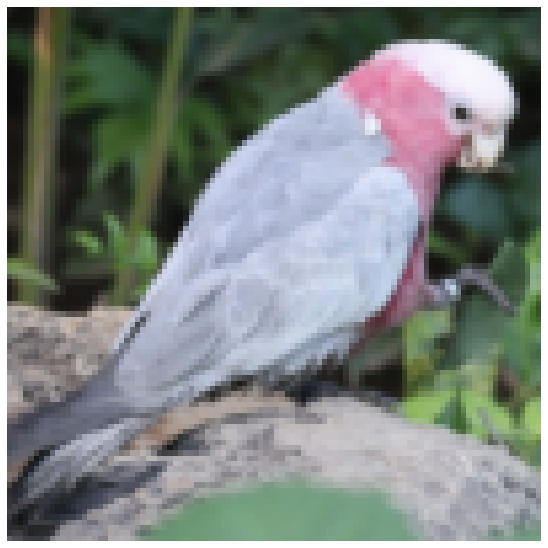

In [7]:
lr_img = blur_img(hr_img)
#lr_img = downscale_img(hr_img)
lr_img = downsample_img(hr_img, factor=8)
plot_img(lr_img)

### Get image tensors and perform cutblur (inside or outside at random)

In [8]:
hr_tensor = im2tensor(hr_img)
lr_tensor = im2tensor(lr_img)*255

In [9]:
_, cut_blurred, region_dict = cutblur(hr_tensor, lr_tensor, 1.0, 0.5)

In [10]:
cut_blurred_img = tensor2im(cut_blurred)

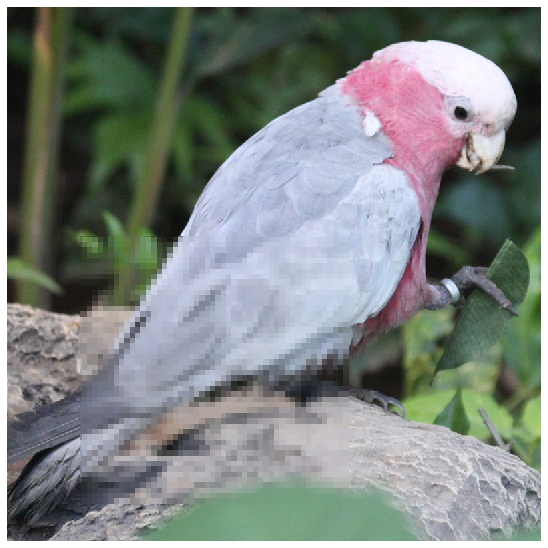

In [11]:
plot_img(cut_blurred_img)

In [12]:
region_dict

{'cy': 343, 'cx': 110, 'ch': 402, 'cw': 402}

#### Visualize the bbox (inside - box is on the LR region, outside - box is on the HR region)

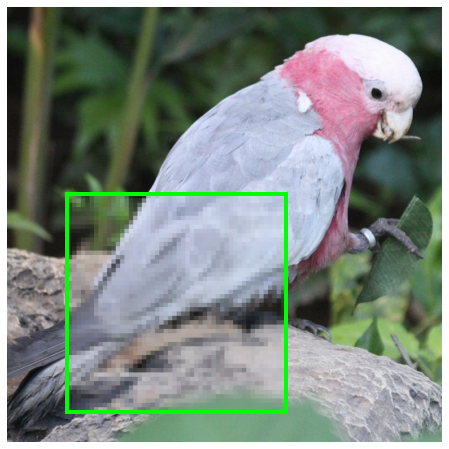

In [13]:
vis_regions(cut_blurred_img, region_dict)

#### Simulate this over multiple instances

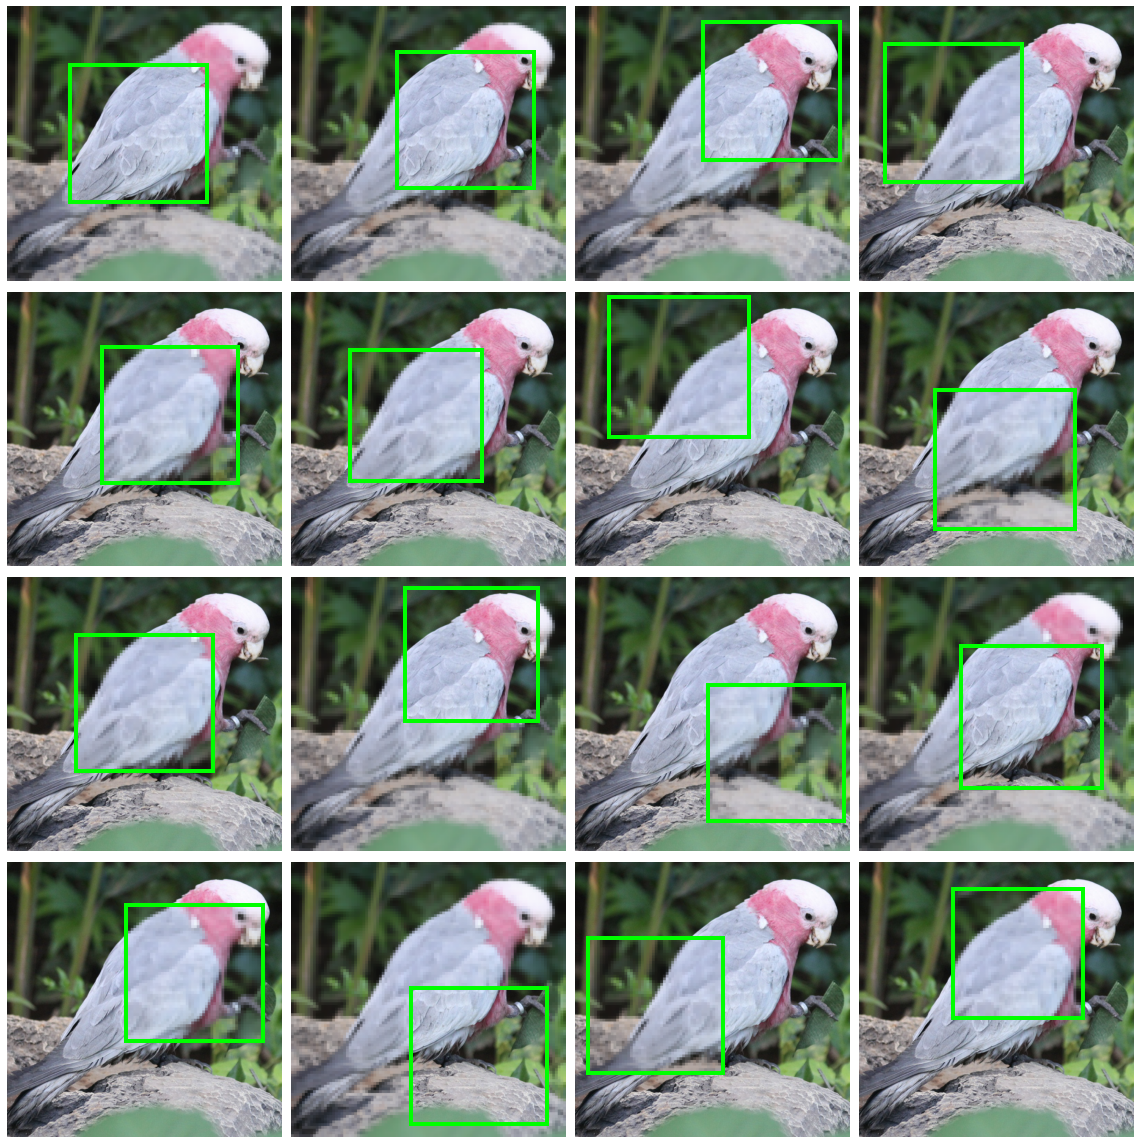

In [14]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(16,16))
for r in range(4):
    for c in range(4):
        hr_tensor = im2tensor(hr_img)
        lr_tensor = im2tensor(lr_img)*255
        _, cut_blurred, region_dict = cutblur(hr_tensor, lr_tensor, 1.0, 0.5)
        cut_blurred_img = tensor2im(cut_blurred)
        ax[r][c].imshow(cut_blurred_img)
        rect = mpatches.Rectangle((region_dict['cx'], region_dict['cy']), 
                                  region_dict['cw'],
                                  region_dict['ch'],
                                  fill=False, edgecolor='lime', linewidth=4)
        ax[r][c].add_patch(rect)
        ax[r][c].axis('off')
plt.tight_layout()
plt.show()